In [30]:
!pip install torch==2.1
!pip install pandas
!pip install numpy

import torch
import torchvision
from torch import nn
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [22]:
train_directory = "archive/Training"
test_directory = "archive/Testing"

In [23]:
# Function to get Mean and STD
"""
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_count = 0
    for images, _ in loader:
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_count += image_count_in_batch

    mean /= total_count
    std /= total_count

    return mean, std
"""

'\ndef get_mean_and_std(loader):\n    mean = 0\n    std = 0\n    total_count = 0\n    for images, _ in loader:\n        image_count_in_batch = images.size(0)\n        images = images.view(image_count_in_batch, images.size(1),-1)\n        mean += images.mean(2).sum(0)\n        std += images.std(2).sum(0)\n        total_count += image_count_in_batch\n\n    mean /= total_count\n    std /= total_count\n\n    return mean, std\n'

In [24]:
# Find the Mean and STD of the dataset
"""
training_mean_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()
])

training_mean_dataset = torchvision.datasets.ImageFolder(root=train_directory, transform=training_mean_transform)

train_loader = torch.utils.data.DataLoader(dataset=training_mean_dataset, batch_size=32, shuffle=False)

get_mean_and_std(train_loader)
"""

'\ntraining_mean_transform = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((224,224)),\n    torchvision.transforms.ToTensor()\n])\n\ntraining_mean_dataset = torchvision.datasets.ImageFolder(root=train_directory, transform=training_mean_transform)\n\ntrain_loader = torch.utils.data.DataLoader(dataset=training_mean_dataset, batch_size=32, shuffle=False)\n\nget_mean_and_std(train_loader)\n'

----

In [25]:
# PyTorch transform image set up

transform_train = torchvision.transforms.Compose([
    # Resize all images to 224 x 224 pixel image
    torchvision.transforms.Resize((224,224)),

    # Give the image a random crop
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomResizedCrop(size=(224,224), scale=(0.8,1.0), ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.1794, 0.1794, 0.1794],std=[0.1723, 0.1723, 0.1723])
])


transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.1794, 0.1794, 0.1794], std=[0.1723, 0.1723, 0.1723])
])

In [26]:
# Import images
train_dataset = torchvision.datasets.ImageFolder(root=train_directory, transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder(root=test_directory, transform=transform_test)


In [27]:
# Show Transformed Images

def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 3, 1, 0, 1])


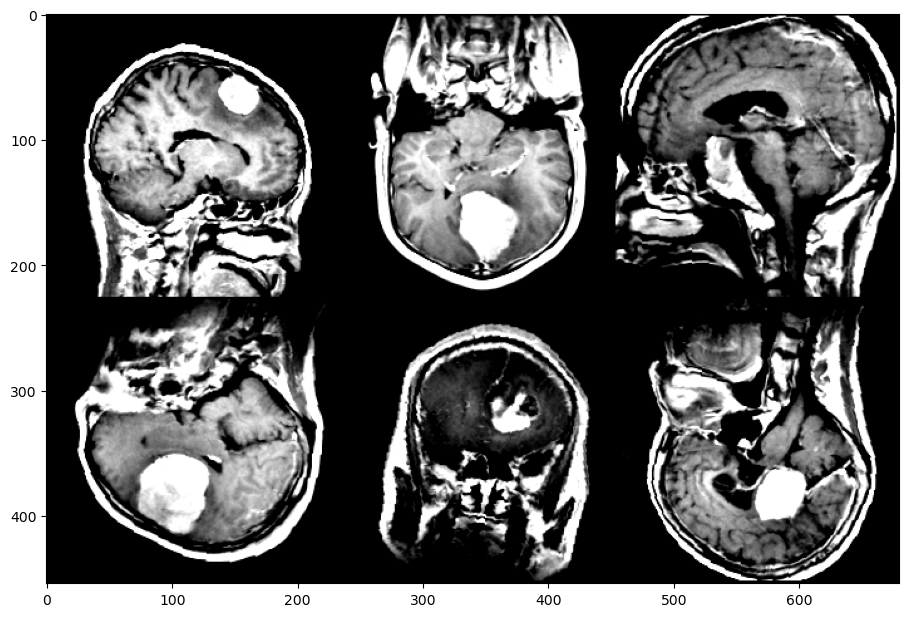

In [28]:
show_transformed_images(train_dataset)

----
# Setting up DenseNet
----

In [ ]:
# DenseLayer or Convolutional Layer

class DenseLayer(nn.Module):
    def __init__(self,input_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.conv = nn.LazyConv2d(input_channels, growth_rate,kernel_size=3, stride=1, padding=1)
        self.norm = nn.LazyBatchNorm2d(growth_rate)
        self.reLU = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.reLU(self.norm(self.conv(x)))],1)

In [ ]:
# DenseBlock

class DenseBlock(nn.Module):
    def __init__(self, num_layers, input_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers=[]
        for i in range(num_layers):
            layers.append(DenseLayer(input_channels + i * growth_rate, growth_rate))
        self.layers = nn.Sequential(*layers)

    def forward(self,x):
        return self.layers(x)

In [ ]:
# Transition Layers

class TransitionLayer(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(TransitionLayer, self).__init__()
        self.norm = nn.LazyBatchNorm2d(input_channels)
        self.reLU = nn.ReLU(inplace=True)
        self.conv = nn.LazyConv2d(input_channels, output_channels, kernel_size=1, stride=1, padding=0)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.norm(x)
        x = self.reLU(x)
        x = self.conv(x)
        x = self.avg_pool(x)
        return x

----
# Constructing the Model
----

In [ ]:
class DenseNet121(nn.Module):

    def __init__(self, num_channels=64, growth_rate=32, num_classes=10):
        super(DenseNet121, self).__init__()

        # Initial Convolution
        self.initial_conv = nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3)
        self.initial_norm = nn.LazyBatchNorm2d(num_channels)
        self.initial_reLU = nn.ReLU()
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # DenseNet-121 Configuration
        block_config = [6, 12, 24, 16]

        self.dense_blocks = nn.ModuleList([])
        self.transition_layers = nn.ModuleList([])

        for num_layers in block_config:
            block = DenseBlock(num_layers=num_layers, input_channels=num_channels, growth_rate=growth_rate)
            self.dense_blocks.append(block)

            # The number of output channels in the previous dense block
            num_channels += num_layers * growth_rate

            # A transition layer that halves the number of channels is added between the dense blocks
            if num_layers != block_config[-1]: # no transition layer after the last block
                trans = TransitionLayer(input_channels=num_channels, output_channels=num_channels//2)
                self.transition_layers.append(trans)
                num_channels = num_channels // 2

        # Final Batch Norm
        self.final_norm = nn.LazyBatchNorm2d(num_channels)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layer
        self.fully_conn = nn.LazyLinear(num_channels, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_norm(x)
        x = self.initial_reLU(x)
        x = self.initial_pool(x)

        # Apply Dense Blocks and Transition Layers
        for i, block in enumerate(self.dense_blocks):
            x = block(x)
            if i < len(self.transition_layers):
                x = self.transition_layers[i](x)

        x = self.final_norm(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fully_conn(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet121(num_classes=4).to(device)

optimizer=Adam(model.parameters(),lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()
